# Fast Bayesian Force Fields from Active Learning: Study of Inter-Dimensional Transformation of Stanene

Yu Xie, Harvard SEAS

This notebook provides scripts for postprocessing, data analysis and generating figures in the paper

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## On-the-fly training

The mean square displacement and DFT calls are obtained from the on-the-fly training trajectory

(0.001, 123.69885976540954)

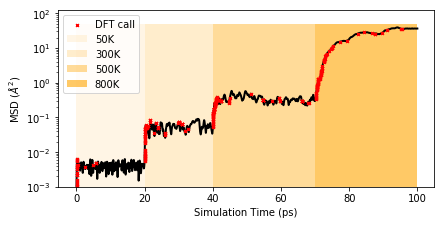

In [2]:
msd = np.load("OTF/MSD.npy")
dft_call = np.load("OTF/DFT_calls.npy")

plt.figure(figsize=(6.75, 3.25))
t = np.arange(len(msd)) / 1000

plt.plot(t, msd, color="k", linewidth=2, zorder=1)
plt.scatter(dft_call / 1000, msd[dft_call], s=8, marker="x", color="r", zorder=2, label="DFT call")
plt.fill_between([0,  20],  [50, 50], color="orange", alpha=0.1, label="50K", linewidth=0.0)
plt.fill_between([20, 40],  [50, 50], color="orange", alpha=0.2, label="300K", linewidth=0.0)
plt.fill_between([40, 70],  [50, 50], color="orange", alpha=0.4, label="500K", linewidth=0.0)
plt.fill_between([70, 100], [50, 50], color="orange", alpha=0.6, label="800K", linewidth=0.0)

plt.yscale("log")
plt.xlabel("Simulation Time (ps)")
plt.ylabel("MSD ($\AA^2$)")
plt.legend()
plt.ylim(bottom=1e-3)

## Hierarchical training

Three iterations of hierarchical training on 200 atoms. The MGP uncertainty of the frames in the LAMMPS trajectory is plotted below. 

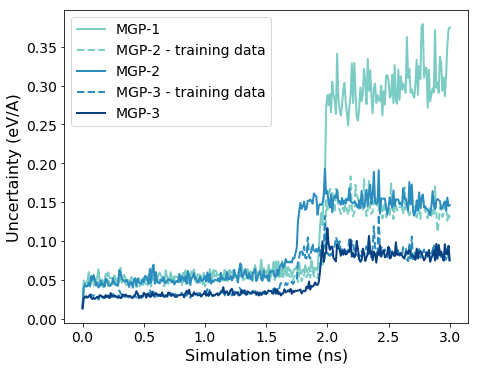

In [3]:
def load_plot(filename, interval, mean=False):
    v = np.load(filename)
    v_old = []
    for i in range(v.shape[0]):
        if mean:
            v_old.append(np.mean(np.sqrt(v[i]**2+0.1556**2)))
        else:
            v_old.append(np.max(np.sqrt(v[i]**2)))#+0.1556**2)))
    v_old = np.array(v_old)
    t = np.arange(len(v_old)) / interval
    return t, v_old



#plt.switch_backend('agg')
colors = ['#1f78b4', '#a6cee3', '#b2df8a']
colors = ['#66c2a5', '#fc8d62', '#8da0cb']
colors = ['#1b9e77', '#d95f02', '#7570b3']
colors = ['#7bccc4', '#2b8cbe', '#084081']

fig, ax = plt.subplots(1, 1, figsize=(6.75, 5.25)) #, gridspec_kw={'width_ratios': [2, 1]})
w = 2

dt = 100
path = "Hierarchical"
t, v = load_plot(f'{path}/mgp-1_v.npy', dt)
ax.plot(t, v, c=colors[0], linewidth=w, label='MGP-1')

t, v = load_plot(f'{path}/mgp-2_train_v.npy', dt) 
ax.plot(t, v, '--', c=colors[0], linewidth=w, 
        label='MGP-2 - training data')

t, v = load_plot(f'{path}/mgp-2_v.npy', dt)
ax.plot(t, v, c=colors[1], linewidth=w, label='MGP-2')

t, v = load_plot(f'{path}/mgp-3_train_v.npy', dt)
ax.plot(t, v, '--', c=colors[1], linewidth=w, 
        label='MGP-3 - training data')

t, v = load_plot(f'{path}/mgp-3_v.npy', dt)
ax.plot(t, v, c=colors[2], linewidth=w, label='MGP-3')

ax.set_xlabel('Simulation time (ns)', fontsize=16)
ax.set_ylabel('Uncertainty (eV/A)', fontsize=16)
ax.tick_params(labelsize=14)
ax.legend(prop={'size': 14})
plt.tight_layout()    
plt.show()

The MGP force accuracy is validated via comparing DFT forces and LAMMPS forces

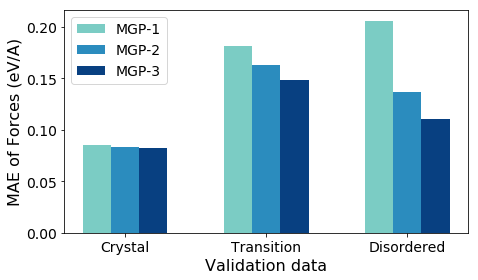

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6.75,4))
# The error is from LAMMPS test
errs = np.array([[0.0852, 0.181, 0.206],
                 [0.0835, 0.163, 0.137],
                 [0.0822, 0.148, 0.110]])

x = np.array([1, 2, 3]) * 4
ax.bar(x-0.8, errs[0,:], color=colors[0], label='MGP-1') 
ax.bar(x    , errs[1,:], color=colors[1], label='MGP-2') 
ax.bar(x+0.8, errs[2,:], color=colors[2], label='MGP-3')

ax.tick_params(labelsize=14)
plt.xticks(x, ('Crystal', 'Transition', 'Disordered'))
ax.set_xlabel('Validation data', fontsize=16)
ax.set_ylabel('MAE of Forces (eV/A)', fontsize=16)
ax.legend(prop={'size': 14})
plt.tight_layout()
plt.show()

## Timing

- Comparison of speed of different methods: DFT, GP, MGP (python, force + uncertainty), MGP (python, force), MGP (LAMMPS, force), Bond Order Potential (LAMMPS, force).

- Tests are done on 
    - different system sizes for prediction: 32 atoms, and 200 atoms
    - and different training set size: 100 and 400 atomic environments

100 200 3.28364013671875 0.0025896404849158395 0.011365644401974148
400 200 14.843310504489475 0.002621707386440701 0.011851112047831217


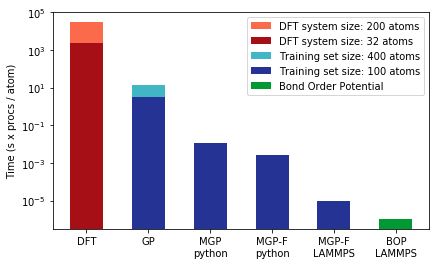

In [5]:
DFT_32 = 462 * 160 / 32 # time * processors / atoms
DFT_200 = 14353 * 448 / 200

# LAMMPS
t_mgp_lmp = 1 / 503.884 / 200 
t_bop_lmp = 1/ 4794.323 / 200 

path = "Timing/Py_GP_MGP"

def read_data(train_size, test_size):
    # remove the first frame (overhead)
    f_t_env = np.loadtxt(f'{path}/t_env-{train_size}-{test_size}')[test_size:]
    f_t_gp = np.loadtxt(f'{path}/t_gp-{train_size}-{test_size}')[1:]
    f_t_mgp = np.loadtxt(f'{path}/t_mgp-{train_size}-{test_size}')[test_size:]
    f_t_mgp_v = np.loadtxt(f'{path}/t_mgp_v-{train_size}-{test_size}')[test_size:]
    
    n_frames = 10 - 1
    
    # get time per atom
    n_cpus = np.min((test_size, 64))
    
    t_gp = (np.sum(f_t_gp) - np.sum(f_t_env)) / n_frames / test_size * n_cpus
    t_mgp = np.mean(f_t_mgp)
    t_mgp_v= np.mean(f_t_mgp_v)
    
    print(train_size, test_size, t_gp, t_mgp, t_mgp_v)
    
    return t_gp, t_mgp_v, t_mgp


data100 = read_data(100, 200)
data400 = read_data(400, 200)

ticks = np.arange(6) * 1.5
tick_labels = ['DFT', 'GP', 'MGP\npython', 'MGP-F\npython', 'MGP-F\nLAMMPS', 'BOP\nLAMMPS']
bias = 0.4
bottom_color = '#253494'
top_color = '#41b6c4'
plt.figure(figsize=(6.75, 4))
plt.bar([ticks[0]], [DFT_200], color='#fb6a4a', label='DFT system size: 200 atoms')
plt.bar([ticks[0]], [DFT_32], color='#a50f15', label='DFT system size: 32 atoms')
plt.bar(ticks[1:4], data400, color=top_color, label='Training set size: 400 atoms')
plt.bar(ticks[1:4], data100, color=bottom_color, label='Training set size: 100 atoms')
plt.bar([ticks[4]], [t_mgp_lmp], color=bottom_color)
plt.bar([ticks[5]], [t_bop_lmp], color='#009933', label='Bond Order Potential')

plt.xticks(ticks, tick_labels)
plt.yscale('log')
plt.ylabel('Time (s x procs / atom)')
plt.legend()
plt.show()

The MGP speed in LAMMPS is tested for 2D honeycomb lattice of stanene, and 3D dense liquid phase, on different system sizes up to 1 million atoms

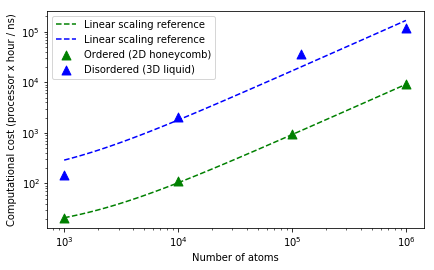

In [6]:
def plot_scaling(size, times, label, color):
    linear_scale = np.poly1d(np.polyfit(size, times, 1, w=[50, 10, 5, 1]))
    x_range = 10 ** np.linspace(3, 6, 100)
    refer = linear_scale(x_range)
    plt.scatter(size, times, s=80, marker='^', color=color, label=label)
    plt.plot(x_range, refer, '--', color=color, label='Linear scaling reference') 

plt.figure(figsize=(6.75, 4))

# The numerical values are extracted from lammps log file
order_size = 10 ** np.arange(3, 7)
order_time = np.array([0.161, 0.856, 7.273, 71.029]) * 128
plot_scaling(order_size, order_time, 'Ordered (2D honeycomb)', color='green')

disord_size = np.array([1e3, 1e4, 1.2e5, 1e6])
disord_time = np.array([1.122, 15.983, 277.472, 473.106*2]) * 128
plot_scaling(disord_size, disord_time, 'Disordered (3D liquid)', color='blue')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of atoms')
plt.ylabel('Computational cost (processor x hour / ns)')
plt.legend()
plt.show()

# Supplementary materials

The figures below are presented in the supplementary materials

## Convergence 

The force and uncertainty accuracy of MGP with respect to a fixed GP is tested, with different grid numbers and ranks

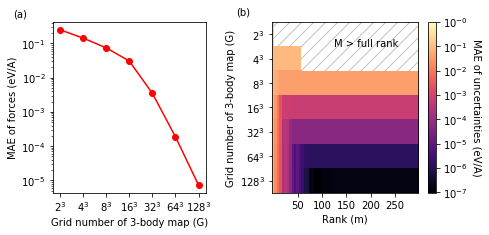

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3.5), gridspec_kw={'width_ratios': [1, 1.2]})

# plot forces convergence with grid number
f = open("Convergence/mae_force.dat")
mae_list = []
for line in f.readlines():
    if "MAE" in line:
        line = line.split()
        grid_pow = int(line[2])
        mae = float(line[3])
        mae_list.append(mae)
ax = axes[0]
ax.plot(mae_list, "-o", color="red")
grid_pow = 2 ** np.arange(1, 8)
ax.set_xticks(np.arange(7))
ax.set_xticklabels(["$"+str(g)+"^3$" for g in grid_pow])
ax.set_yscale("log")
ax.set_xlabel("Grid number of 3-body map (G)")
ax.set_ylabel("MAE of forces (eV/A)")

ax.text(s="(a)", fontsize=10, x=-2, y=0.6)

# plot uncertainty convergence with grid num and rank
f = open("Convergence/mae_uncertainty.dat")

grid_pow = []
rank = []
mae = []

mae_matr = np.ones((7, 60))
 
for line in f.readlines():
    if "MAE" in line:
        line = line.split()
        grid_pow = int(line[1])
        rank = int(line[2])
        mae = float(line[3])
        mae_matr[grid_pow-1, rank//5-1] = mae

mae_matr = np.log(mae_matr) / np.log(10)
ax = axes[1]
img = ax.imshow(mae_matr, aspect="auto", cmap=plt.get_cmap("magma"))
cbar = fig.colorbar(img)
cbar.ax.set_ylabel("MAE of uncertainties (eV/A)", rotation=-90, va="bottom")
cbar.ax.set_yticklabels(["$10^{-"+str(g)+"}$" for g in range(7, -1, -1)])

grid_pow = 2 ** np.arange(1, 8)
ax.set_yticks(np.arange(7))
ax.set_yticklabels(["$"+str(g)+"^3$" for g in grid_pow])

ax.set_xticks(np.arange(1, 6) * 10)
ax.set_xticklabels(np.arange(1, 6) * 50)

ax.set_xlabel("Rank (m)")
ax.set_ylabel("Grid number of 3-body map (G)")

ax.text(s="M > full rank", fontsize=10, x=25, y=0.5)

mpl.rcParams['hatch.color'] = "silver"

left, bottom, width, height = (0.5, -0.5, 59, 1)
rect = plt.Rectangle((left, bottom), width, height,
                     facecolor="white", hatch='//')

ax.add_patch(rect)

left, bottom, width, height = (11.5, 0.5, 50, 1)
rect = plt.Rectangle((left, bottom), width, height,
                     facecolor="white", hatch='//')

ax.add_patch(rect)

ax.text(s="(b)", fontsize=10, x=-15, y=-0.8)

plt.tight_layout(pad=1.5)
plt.show() 

## Phonon

- The model also includes some bulk configurations of $\alpha$, $\beta$ and bcc phases. 

- The training set consists of:
    melting stanene (472) + $\alpha$ phase (200) + $\beta$ phase (200) + bcc phase (99) = 971 atomic environments

- Two models are tested and compared for phonon dispersion:
    1. $\text{MGP}_{f-label}$: only includes forces as training labels
    2. $\text{MGP}_{e-label}$: besides forces, also includes 5 frames of global energies of $\alpha$ and 5 frames of $\beta$

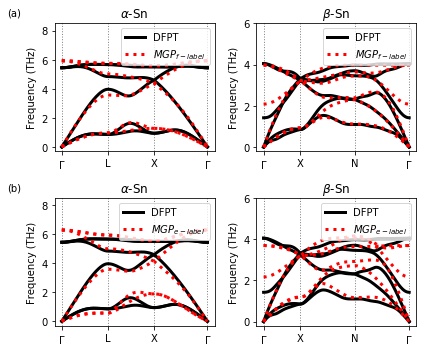

In [8]:
# plot mgp phonon
phase_list = ["alpha", "beta"]
phase = "alpha"
fig, axes = plt.subplots(2, 2, figsize=(3 * 2, 2.5 * 2))
model_list = ["mgp_absb_force_diffcut", "mgp_absb_diffcut"]
model_name = [r"$MGP_{f-label}$", r"$MGP_{e-label}$"]
panel_name = ["(a)", "(b)"]

for j, mdl in enumerate(model_list):
    for i, phase in enumerate(phase_list):
        if phase == "beta":
            high_sym_labels = ["$\Gamma$", "X", "N", "$\Gamma$"]
            top = 6
        elif phase == "alpha":
            high_sym_labels = ["$\Gamma$", "L", "X", "$\Gamma$"]
            top = 8.5
    
        mgp_path = np.load(f"Bulk/{phase}/phonon/{mdl}/xcoords.npy")
        mgp_bands = np.load(f"Bulk/{phase}/phonon/{mdl}/energies.npy")[0]
        mgp_bands *= 241.79893 # 1 eV = 241.79893 THz
        
        data = np.loadtxt(f"Bulk/{phase}/phonon/matdyn/{phase}.freq.gp")
        path = data[:,0]
        bands = data[:,1:] * 0.02998 # 1 cm^-1 = 0.02998 THz
        
        path = np.array(path)
        path *= mgp_path[-1] / path[-1]
        
        ax = axes[j, i]
    
        high_sym_pts = [path[i * 51] for i in range(4)]
        for p in high_sym_pts:
            ax.axvline(x=p, linestyle=":", linewidth=1, color="gray")
        
        mgp_line = ":"
        mgp_color = "r"
        dft_line = "-"
        dft_color = "k"
        ax.plot(path, bands[:,0], dft_line, linewidth=3, color=dft_color, label="DFPT")
        ax.plot(path, bands[:,1:], dft_line, linewidth=3, color=dft_color)
        ax.plot(mgp_path, mgp_bands[:,0], mgp_line, linewidth=3, color=mgp_color, label=model_name[j])
        ax.plot(mgp_path, mgp_bands[:,1:], mgp_line, linewidth=3, color=mgp_color)
    
        ax.set_xticks(high_sym_pts)
        ax.set_xticklabels(high_sym_labels)
        ax.set_ylabel("Frequency (THz)")
        ax.set_ylim(top=top)
        ax.legend(loc='upper right')
        ax.set_title(f"$\{phase}$-Sn")
        if i == 0:
            ax.text(x=-1, y=9, s=panel_name[j])

plt.tight_layout()
plt.show()

## Radial distribution function

- The RDF of MGP LAMMPS simulation are presented, and compared with perfect bcc Sn (low temperature), and AIMD of melted Sn (high temperature)

- RDF files of single frames are obtained from OVITO, and then averaged by a python script, saved as `rdf.***average.txt`. 

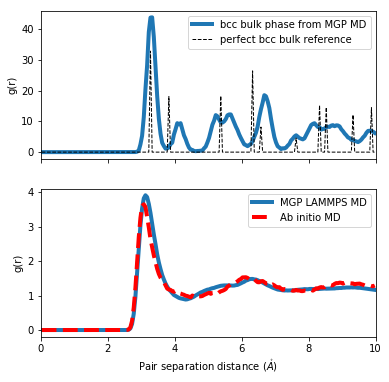

In [9]:
def read_rdf(path, idx, normalize):
    dist = []
    rdf = []
    for i in idx:
        data = np.loadtxt(f"{path}/rdf.{i}.txt")
        dist.append(data[:, 0])
        rdf.append(data[:,1])
    dist = np.mean(dist, axis=0)
    rdf = np.mean(rdf, axis=0)
    if normalize:
        rdf /= np.mean(rdf)
    return dist, rdf

fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
mgp_color = "tab:blue"

# plot bulk RDF
ax = axes[0]
bulk_path = "Bulk/bcc/Atoms3k_Temp200K/postprocess/"

dist, rdf = read_rdf(bulk_path, ["md"], normalize=False)
ax.plot(dist, rdf, linewidth=4, color=mgp_color, label="bcc bulk phase from MGP MD")

dist, rdf = read_rdf(bulk_path, ["perfect_bcc"], normalize=False)
ax.plot(dist, rdf, "--", linewidth=1, color="black", label="perfect bcc bulk reference")

ax.legend()
ax.set_ylabel("g(r)")

# plot liquid RDF
ax = axes[1]

dist, rdf = read_rdf("Liquid/LMP/Atoms10k_Temp500K/RDF", ["550-600average"], normalize=True)
ax.plot(dist, rdf, linewidth=4, color=mgp_color, label="MGP LAMMPS MD")

dist, rdf = read_rdf("Liquid/AIMD/AIMD_smallcell_500K", ["1000-2217average"], normalize=True)
ax.plot(dist, rdf, "--", linewidth=4, color="red", label="Ab initio MD")
ax.legend()
ax.set_ylabel("g(r)")


plt.xlim([0, 10])

plt.xlabel("Pair separation distance ($\mathring{A}$)")
plt.show()